In [1]:
%%capture
## compile PyRoss for this notebook
import os
owd = os.getcwd()
os.chdir('../../')
%run setup.py install
os.chdir(owd)

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt
import pyross
import time 

In [2]:
M  = 2          # the population has two age groups
N  =  5e4           # and this is the total population

# correct params

beta  = 0.02         # infection rate
gIa   = 1./7            # recovery rate of asymptomatic infectives
gIs   = 1./7            # recovery rate of asymptomatic infectives
alpha = 0.2          # fraction of asymptomatic infectives
fsa   = 1          # the self-isolation parameter

# set the age structure
fi = np.array([0.25, 0.75])  # fraction of population in age age group
Ni = N*fi

# set the contact structure
C = np.array([[18., 9.], [3., 12.]])

# set up initial condition
Ia0 = np.array([20, 20])  # each age group has asymptomatic infectives
Is0 = np.array([20, 20])   # and also symptomatic infectives
R0  = np.array([0, 0])  # there are no recovered individuals initially
S0  = Ni - (Ia0 + Is0 + R0)

Tf = 100
Nf = Tf+1

def contactMatrix(t):
    return C

parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}

# use pyross stochastic to generate traj and save 
sto_model = pyross.stochastic.SIR(parameters, M, Ni)
data = sto_model.simulate(S0, Ia0, Is0, contactMatrix, Tf, Nf)
data_array = data['X']
np.save('latent_SIR_traj.npy', data_array)

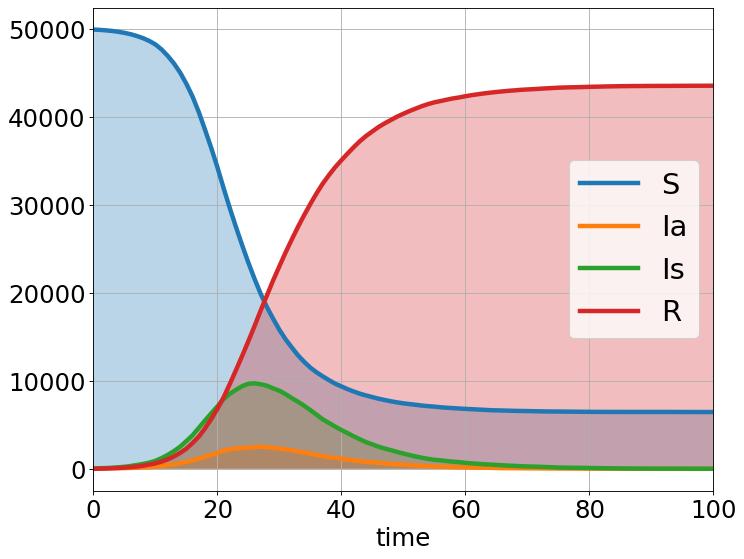

In [3]:
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
t = data['t']

plt.fill_between(t, 0, np.sum(data_array[:, :M], axis=1),  alpha=0.3)
plt.plot(t, np.sum(data_array[:, :M], axis=1), '-', label='S', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, M:2*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, M:2*M], axis=1), '-', label='Ia', lw=4)

plt.fill_between(t, 0, np.sum(data_array[:, 2*M:3*M], axis=1), alpha=0.3)
plt.plot(t, np.sum(data_array[:, 2*M:3*M], axis=1), '-', label='Is', lw=4)

plt.fill_between(t, 0, N - np.sum(data_array[:, :], axis=1), alpha=0.3)
plt.plot(t, N - np.sum(data_array[:, :], axis=1), '-', label='R', lw=4)

plt.legend(fontsize=26)
plt.grid() 
plt.xlabel(r'time') 
plt.autoscale(enable=True, axis='x', tight=True)

In [4]:
# load the data and rescale to intensive variables 
Tf_inference = 20
Nf_inference = Tf_inference + 1

x = np.load('latent_SIR_traj.npy').astype('float')
x = (x/N)[:Nf_inference]
steps = 10 # number internal integration steps taken, must be an odd number 

# initialise the estimator 
estimator = pyross.inference.SIR(parameters, M, fi, int(N), steps)

In [5]:
# a filter that sums over all the infected people for each age group
fltr = np.kron([0, 1, 1],np.identity(M))
print(fltr)

[[0. 0. 1. 0. 1. 0.]
 [0. 0. 0. 1. 0. 1.]]


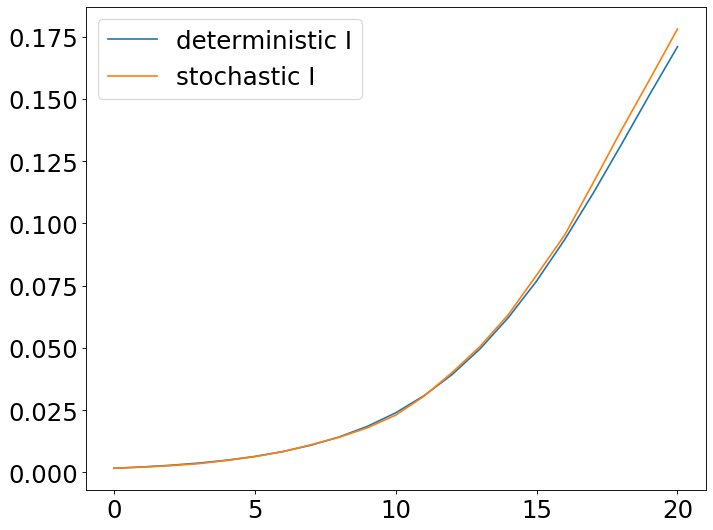

In [6]:
# Compare the deterministic trajectory and the stochastic trajectory with the same 
# initial conditions and parameters 
obs=np.einsum('ij,kj->ki', fltr, x)

x0=x[0]
det_model = estimator.make_det_model(parameters)
xm = estimator.integrate(x[0], 0, Tf_inference, Nf_inference, det_model, contactMatrix)
det_obs = np.einsum('ij,kj->ki', fltr, xm)
fig = plt.figure(num=None, figsize=(10, 8), dpi=80, facecolor='w', edgecolor='k')
plt.rcParams.update({'font.size': 22})
plt.plot(np.sum(det_obs, axis=1), label='deterministic I')
plt.plot(np.sum(obs, axis=1), label='stochastic I')
plt.legend()
plt.show()

In [7]:
# compute -log_p for the original (correct) parameters 
start_time = time.time() 
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
logp = estimator.minus_logp_red(parameters, x0, obs[1:], fltr, Tf_inference, Nf_inference, contactMatrix, tangent=True)

end_time = time.time()
print(logp) 
print(end_time - start_time)

-265.4762975766815
0.036685943603515625


In [8]:
# make parameter guesses and set up bounds for each parameter 
eps=1e-4

alpha_g = 0.22
alpha_std = 0.1
alpha_bounds = (eps, 1-2*eps)
# the bound for alpha must be 1-2*eps to avoid alpha>1 in hessian calculation performed by optimizer 

beta_g = 0.04
beta_std = 0.05
beta_bounds = (eps, 0.2)

gIa_g = 0.13
gIa_std = 0.05
gIa_bounds = (eps, 0.5)

gIs_g = 0.14
gIs_std = 0.05
gIs_bounds = (eps, 0.5) 

# not inferred 
fsa_g = 0.8

Ia0_g = (Ia0+3)/N
Ia_std = Ia0_g*0.5
bounds_for_Ia = np.tile([0.1/N, 100/N], M).reshape(M, 2)

S0_g = (S0+3)/N # need the sum of S0_g + I0 (observed in this case) over each age group to be smaller than fi 
S_std = Ia_std*5
bounds_for_S = np.array([(0.1/N, f-1/N) for f in fi]).reshape(M, 2)

# optimisation parameters 
ftol = 1e-5 # the relative tol in (-logp)  

# set up bounds, guess and stds for the rest of the params 
keys = ['alpha', 'beta', 'gIa', 'gIs']
bounds = np.array([alpha_bounds, beta_bounds, gIa_bounds, gIs_bounds, 
                   *bounds_for_S, *bounds_for_Ia])
guess = np.array([alpha_g, beta_g, gIa_g, gIs_g, *S0_g, *Ia0_g])
stds = np.array([alpha_std, beta_std, gIa_std, gIs_std, *S_std, *Ia_std])

# set up fltr for initial conditions because they are constraint by the observed 
init_fltr = np.repeat([True, True, False], M)

start_time = time.time()
params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=True, 
                                    global_max_iter=15, global_ftol_factor=1, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=2586288116, Wed May 27 13:59:46 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 -1.053274710249952e+02 1.0e+00 9.72e-01  2e-04  9e-02 0:00.2
    2     32 6.628651960530152e+03 1.3e+00 1.02e+00  2e-04  1e-01 0:00.3
    3     48 5.315891027806470e+03 1.4e+00 1.13e+00  2e-04  1e-01 0:00.4
    5     80 -1.594132694405409e+02 1.8e+00 1.12e+00  2e-04  1e-01 0:00.7
Optimal value (global minimisation):  -205.16466684151044
Starting local minimisation...
Optimal value (local minimisation):  -302.008017060973
1.6118040084838867


In [9]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = estimator.fill_params_dict(keys, params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, Ia0, Is0)

partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))
print('R initial = ', N*(fi - np.sum(x0.reshape((3, 2)), axis=0)))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.2670228793198698, 'beta': 0.01941337141862181, 'gIa': 0.09325228649221753, 'gIs': 0.14429497040272268, 'fsa': array([1., 1.])}

 True initial conditions: 
[12460. 37460.] [20 20] [20 20]

 Inferred initial conditons: 
[12428 37439    23    16    16    23]
R initial =  [31.10795653 20.38287278]


In [10]:
start_time = time.time()
params = estimator.latent_infer_parameters(keys, init_fltr, guess, stds, obs, fltr, Tf_inference, Nf_inference, 
                                    contactMatrix, bounds, 
                                    tangent=False, 
                                    global_max_iter=15, global_ftol_factor=1, 
                                    verbose=True, ftol=ftol) 
end_time = time.time()
print(end_time - start_time)

Starting global minimisation...
(8_w,16)-aCMA-ES (mu_w=4.8,w_1=32%) in dimension 8 (seed=420962994, Wed May 27 13:59:54 2020)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1     16 2.762720573380279e+03 1.0e+00 1.08e+00  2e-04  1e-01 0:01.1
    2     32 1.257878814065884e+04 1.4e+00 1.21e+00  3e-04  1e-01 0:02.1
    3     48 3.489266139239291e+03 1.5e+00 1.18e+00  2e-04  1e-01 0:03.1
    7    112 -2.165484505344126e+02 1.8e+00 1.05e+00  2e-04  1e-01 0:07.1
Optimal value (global minimisation):  -287.8229768259779
Starting local minimisation...
Optimal value (local minimisation):  -300.1818542708051
15.644521951675415


In [11]:
# print the correct params and best estimates 
print('True parameters')
parameters = {'alpha':alpha, 'beta':beta, 'gIa':gIa, 'gIs':gIs,'fsa':fsa}
print(parameters)

best_estimates = estimator.fill_params_dict(keys, params)
print('\n Best estimates')
print(best_estimates)

print('\n True initial conditions: ') 
print(S0, Ia0, Is0)

partial_inits = params[len(keys):]
x0 = estimator.fill_initial_conditions(partial_inits, obs[0], init_fltr, fltr)
print('\n Inferred initial conditons: ') 
print((x0*N).astype('int'))
print('R initial = ', N*(fi - np.sum(x0.reshape((3, 2)), axis=0)))

True parameters
{'alpha': 0.2, 'beta': 0.02, 'gIa': 0.14285714285714285, 'gIs': 0.14285714285714285, 'fsa': 1}

 Best estimates
{'alpha': 0.3678870502776945, 'beta': 0.019472575368786726, 'gIa': 0.09004568468536223, 'gIs': 0.16076943266275842, 'fsa': array([1., 1.])}

 True initial conditions: 
[12460. 37460.] [20 20] [20 20]

 Inferred initial conditons: 
[12435 37436    14    21    25    18]
R initial =  [24.7239085  23.81430741]
